In [52]:
import numpy as np
from scipy.spatial import distance_matrix

import matplotlib.pyplot as plt

In [130]:
class GRF():
    def __init__(self, **kwargs):
        super().__init__()
        self.d = kwargs['d']
        self.l = kwargs['l']
        self.lowerbound = kwargs['lowerbound']
        self.upperbound = kwargs['upperbound']
        self.N_samples = kwargs['N_samples']
        self.N_gridpoints = int(1/self.l) + 1
        self.compute_grid()
        self.compute_cov()
        self.compute_GRFpoints()
        self.compute_RBFintcoeffs()
        self.compute_minmax()
        
    def compute_grid(self):
        if self.d==2:
            X, Y = np.mgrid[0:1:self.N_gridpoints*1j, 0:1:self.N_gridpoints*1j]
            self.x_grid = np.vstack([X.ravel(), Y.ravel()]).T
    
    def compute_cov(self):
        self.cov = np.exp(-distance_matrix(self.x_grid, self.x_grid, p=2)**2/(2*self.l**2))
    
    def compute_GRFpoints(self):
        self.f = np.random.multivariate_normal(np.zeros(self.N_gridpoints**self.d), cov=self.cov, size=self.N_samples)
    
    def compute_RBFintcoeffs(self):
        cov_inv = np.linalg.inv(self.cov)
        self.f_hat = np.einsum('nij,nj->ni', np.tile(cov_inv, (self.f.shape[0],1,1)), self.f)
    
    def compute_minmax(self):
        if self.d==2:
            X, Y = np.mgrid[0:1:100*1j, 0:1:100*1j]
            x = np.vstack([X.ravel(), Y.ravel()]).T
        terms = self.f_hat[:,:,None]*np.exp(-np.sum((x[None,None,:,:] - self.x_grid[None,:,None,:])**2, axis=-1)/(2*self.l**2))
        f = np.sum(terms, axis=1)
        self.f_min = np.amin(f)
        self.f_max = np.amax(f)
            
    def RBFint(self, sample):
        def function(x):
            terms = self.f_hat[sample,:,None]*np.exp(-np.sum((x[None,None,:,:] - self.x_grid[None,:,None,:])**2, axis=-1)/(2*self.l**2))
            output = np.sum(terms, axis=1)
            return output
        return function

    def RBFint_pointwise(self, sample):
        def function(x):
            terms = self.f_hat[sample]*np.exp(-np.sum((x - self.x_grid)**2, axis=-1)/(2*self.l**2))
            print(terms.shape)
            output = np.sum(terms)
            return output
        return function
    
    def RBFint_scaled(self, sample):
        def function(x):
            output_scaled = (self.RBFint(sample)(x) - self.f_min)/(self.f_max - self.f_min) #Scale to [0,1]
            output_scaled = (self.upperbound - self.lowerbound)*output_scaled + self.lowerbound #Scale to [lowerbound,upperbound]
            return output_scaled
        return function
            
    def RBFint_pointwise_scaled(self, sample):
        def function(x):
            output_scaled = (self.RBFint_pointwise(sample)(x) - self.f_min)/(self.f_max - self.f_min) #Scale to [0,1]
            output_scaled = (self.upperbound - self.lowerbound)*output_scaled + self.lowerbound #Scale to [lowerbound,upperbound]
            return output_scaled
        return function
    
    def sample(self, f, i):
        def function(x):
            return f(x)[i]
        return function

In [131]:
simparams = {'d': 2,
             'nelems': 32,
             'etype': 'square',
             'btype': 'spline',
             'basisdegree': 1,
             'intdegree': 2,
             'nfemsamples': 2}

p_theta = {'l': 0.4,
        'lowerbound': 0.02,
        'upperbound': 0.99}

p_f = {'l': 0.2,
        'lowerbound': 0.02,
        'upperbound': 0.99}

p_eta = {'l': 0.3,
        'lowerbound': -1,
        'upperbound': 1}

trainingdataparams = {'inputdata': 'grf',
                   'theta': p_theta,
                   'f': p_f,
                   'eta': p_eta,
                   'N_sensornodes': 144,
                   'N_outputnodes': 268,
                   'N_samples': 100}

params = {}
params['trainingdataparams'] = trainingdataparams
params['simparams'] = simparams

In [132]:
GRF = GRF(**simparams, **trainingdataparams, **trainingdataparams['eta'])

(100, 16, 1)
(100, 16, 1)


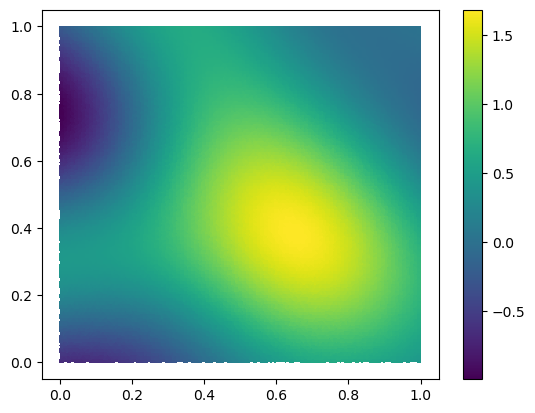

In [133]:
func = GRF.RBFint(sample=4)
X, Y = np.mgrid[0:1:100*1j, 0:1:100*1j]
x_i = np.vstack([X.ravel(), Y.ravel()]).T
func(x_i).shape
plt.tripcolor(x_i[:,0], x_i[:,1], func(x_i)[0])
plt.colorbar()

In [120]:
func(np.array([0.5,0.5]).reshape(1,2))

array([[-0.02620205]])

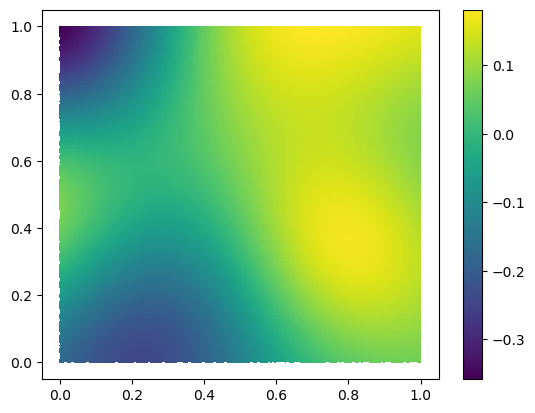

In [124]:
func = GRF.RBFint_scaled(sample=4)
X, Y = np.mgrid[0:1:100*1j, 0:1:100*1j]
x_i = np.vstack([X.ravel(), Y.ravel()]).T
func(x_i).shape
plt.tripcolor(x_i[:,0], x_i[:,1], func(x_i)[0])
plt.colorbar()

In [125]:
func(np.array([0.5,0.5]).reshape(1,2))

array([[0.06044415]])

In [122]:
func = GRF.RBFint_pointwise(sample=4)
X, Y = np.mgrid[0:1:100*1j, 0:1:100*1j]
x_i = np.array([0.5,0.5])
func(x_i)

(16,)


-0.02620204621719613

In [123]:
func = GRF.RBFint_pointwise_scaled(sample=4)
X, Y = np.mgrid[0:1:100*1j, 0:1:100*1j]
x_i = np.array([0.5,0.5])
func(x_i)

(16,)


0.06044415192904529